I use a Generative Adversarial Network GAN in this notebook to generate new dog images from existing ones this  is particularly effective when the dataset is limited as they can create realistic synthetic data.
I use the dataset from the Kaggle competition Generative Dog Images:

 https://www.kaggle.com/competitions/generative-dog-image


 Note :I used Kaggle to create and run this notebook because it offers significant advantages such as access to high RAM, GPU, and TPU resources.

In [1]:
import zipfile
import os

zip_path = "/kaggle/input/generative-dog-images/all-dogs.zip"
extract_path = "/kaggle/working/dogs"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Images extracted:", len(os.listdir(extract_path)))


Images extracted: 1


#  preprocessing data

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

IMAGE_SIZE = 64
BATCH_SIZE = 128

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.ImageFolder(
    root="/kaggle/working",
    transform=transform
)

dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)


# define Generator

In [11]:
import torch.nn as nn

LATENT_DIM = 100

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(LATENT_DIM, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)


# Build Discriminator

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).view(-1)


In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

G = Generator().to(device)
D = Discriminator().to(device)

def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)

G.apply(weights_init)
D.apply(weights_init)


Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [16]:
criterion = nn.BCELoss()

optimizer_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))


# Train descriminitor  and train generator


In [17]:
EPOCHS = 50

for epoch in range(EPOCHS):
    for real_images, _ in dataloader:
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        real_labels = torch.ones(batch_size, device=device)
        fake_labels = torch.zeros(batch_size, device=device)

        #  Train Discriminator 
        optimizer_D.zero_grad()

        real_loss = criterion(D(real_images), real_labels)

        noise = torch.randn(batch_size, LATENT_DIM, 1, 1, device=device)
        fake_images = G(noise)
        fake_loss = criterion(D(fake_images.detach()), fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        #  Train Generator
        
        optimizer_G.zero_grad()

        g_loss = criterion(D(fake_images), real_labels)
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{EPOCHS}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")


Epoch [1/50] | D Loss: 0.1958 | G Loss: 7.7454
Epoch [2/50] | D Loss: 2.1088 | G Loss: 7.6523
Epoch [3/50] | D Loss: 0.2680 | G Loss: 4.3732
Epoch [4/50] | D Loss: 0.2458 | G Loss: 3.9759
Epoch [5/50] | D Loss: 0.4976 | G Loss: 5.3939
Epoch [6/50] | D Loss: 0.6573 | G Loss: 7.2190
Epoch [7/50] | D Loss: 0.2543 | G Loss: 4.1554
Epoch [8/50] | D Loss: 0.9820 | G Loss: 1.3736
Epoch [9/50] | D Loss: 0.4303 | G Loss: 3.1675
Epoch [10/50] | D Loss: 0.2427 | G Loss: 3.1451
Epoch [11/50] | D Loss: 0.6056 | G Loss: 2.8701
Epoch [12/50] | D Loss: 2.6214 | G Loss: 3.1504
Epoch [13/50] | D Loss: 0.8930 | G Loss: 6.1141
Epoch [14/50] | D Loss: 0.5064 | G Loss: 2.5066
Epoch [15/50] | D Loss: 0.7436 | G Loss: 1.3801
Epoch [16/50] | D Loss: 0.3803 | G Loss: 3.4845
Epoch [17/50] | D Loss: 1.2188 | G Loss: 1.1283
Epoch [18/50] | D Loss: 1.2146 | G Loss: 5.6662
Epoch [19/50] | D Loss: 0.5329 | G Loss: 3.5018
Epoch [20/50] | D Loss: 0.7936 | G Loss: 3.9525
Epoch [21/50] | D Loss: 0.6661 | G Loss: 3.5156
E

# Generate new image

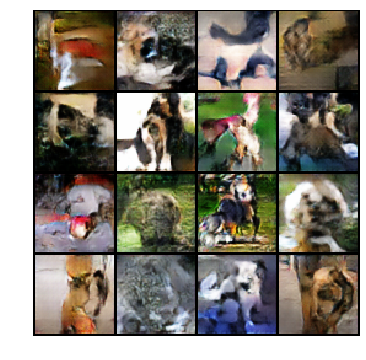

In [18]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt

noise = torch.randn(16, LATENT_DIM, 1, 1, device=device)
fake = G(noise).detach().cpu()

plt.figure(figsize=(6,6))
plt.axis("off")
plt.imshow(
    vutils.make_grid(fake, nrow=4, normalize=True).permute(1,2,0)
)
plt.show()
